In [3]:
# !pip install pyarrow

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os   
import pyarrow.parquet 
import h3

In [5]:
# import geoparquet file + reproject
places_gdf = gpd.read_parquet(os.path.join('data','overture','uk_places_admin.parquet'))
places_gdf = places_gdf.to_crs('EPSG:4326') 

In [7]:
places_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2237195 entries, 0 to 2237194
Data columns (total 49 columns):
 #   Column              Dtype   
---  ------              -----   
 0   id                  object  
 1   updatetime          object  
 2   version             int64   
 3   confidence          float64 
 4   websites            object  
 5   socials             object  
 6   emails              object  
 7   phones              object  
 8   geometry            geometry
 9   names_value         object  
 10  category_main       object  
 11  category_alternate  object  
 12  addresses_postcode  object  
 13  addresses_freeform  object  
 14  addresses_country   object  
 15  addresses_locality  object  
 16  addresses_region    object  
 17  sources_dataset     object  
 18  brand_name_value    object  
 19  lat                 float64 
 20  lng                 float64 
 21  h3_01               object  
 22  h3_02               object  
 23  h3_03               obje

In [8]:
# Import london boundaries
london_boundary = gpd.read_file(os.path.join('data','statistical-gis-boundaries-london','ESRI','London_Ward_CityMerged.shp'))
london_boundary.to_crs(epsg=4326, inplace=True)

# Subset to places_gdf within Greater London Boundaries only
ldn_places_gdf = gpd.sjoin(places_gdf, london_boundary, how='inner', predicate='within')

<Axes: >

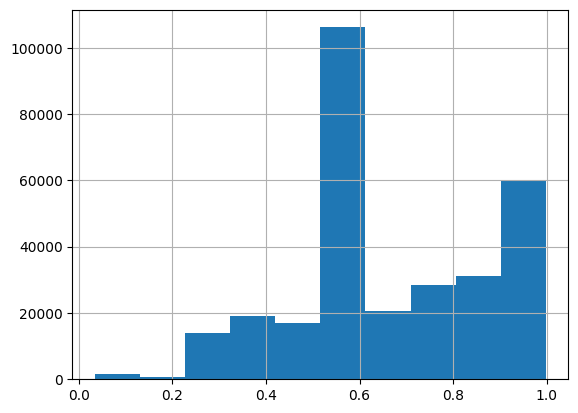

In [11]:
# PLot confidence histogram
ldn_places_gdf['confidence'].hist()

In [43]:
def filter_poi_confidence(df,cl):
    
    # filter by confidence
    df = df[df['confidence'] >= cl]
    
    # group by h3 and category
    poi_h3_count = df.groupby(['h3_09','category_main']).size().reset_index(name='count')
    poi_h3_count = poi_h3_count.pivot(index='h3_09', columns='category_main', values='count').fillna(0)
    poi_h3_count['total'] = poi_h3_count.sum(axis=1) #add total
    poi_h3_count.reset_index(inplace=True)
    poi_h3_count.columns.name = None

    # turn h3 to polygon
    from shapely.geometry import Polygon
    
    def add_geometry(row):
        geom = h3.h3_to_geo_boundary(row["h3_09"],True)
        return Polygon(geom)
    
    poi_h3_count["geometry"] = poi_h3_count.apply(add_geometry, axis = 1) # iterate for each row
    poi_h3_count = gpd.GeoDataFrame(poi_h3_count, crs="EPSG:4326")    # convert gdf

    return poi_h3_count

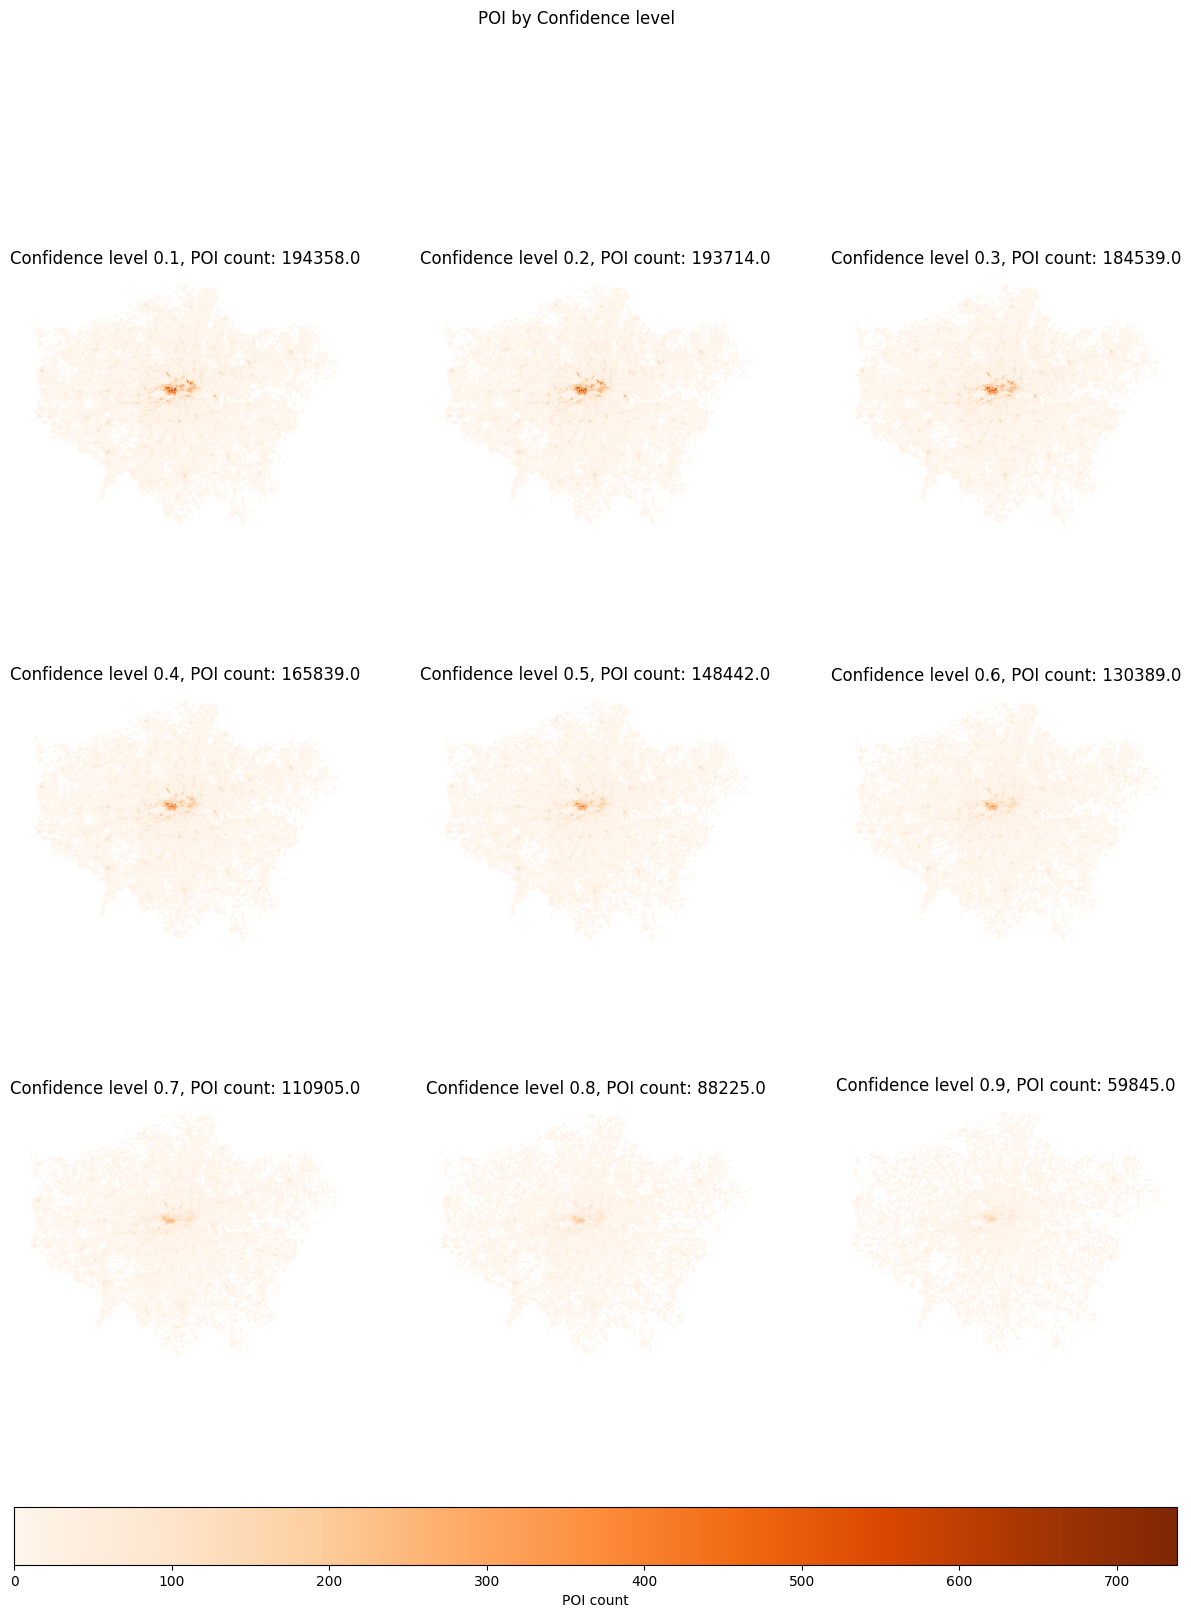

In [58]:
import matplotlib.pyplot as plt

cl_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

fig, ax = plt.subplots(3, 3, figsize=(15, 18))
fig.suptitle(f'POI by Confidence level')

#Make the color map to be the same for all subplots
vmin = 0
vmax = filter_poi_confidence(ldn_places_gdf,0)["total"].max()

for i,cl in enumerate(cl_list):    
    poi_h3_count = filter_poi_confidence(ldn_places_gdf,cl)
    poi_h3_count.plot(column='total',legend=False, ax=ax[i//3,i%3], cmap='Oranges',vmin=vmin, vmax=vmax)
    ax[i//3,i%3].axis('off')
    ax[i//3,i%3].set_title(f'Confidence level {cl}, POI count: {poi_h3_count["total"].sum()}')

# add shared legend color bar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax)), ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('POI count')

plt.show()

In [55]:
poi_odf_hex = filter_poi_confidence(ldn_places_gdf,0.5)
poi_odf_hex.to_file(os.path.join('data','poi_odf_h3_count.geojson'), driver='GeoJSON')